In [1]:

import torch
from tqdm import tqdm

if torch.cuda.is_available():
    print("GPU is available")
    import cupy as np
else:
    print("GPU is not available")
    import numpy as np

GPU is available


/home/acnagle/miniconda3/envs/ddad/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np

In [3]:
import sys
np.set_printoptions(threshold=sys.maxsize)
class BBG:
	def __init__(self, alpha: float=2.0, epsilon: float=1.0):
		self.alpha = alpha
		self.epsilon = epsilon
	
	#mxn matrix -> m points, each are in R^n. 
	def run(self, points: np.ndarray, k: int=-1):
		m = points.shape[0]
		n = points.shape[1]
		print("b condition: ", (1 + 5/self.alpha)*self.epsilon*m)
		print("total points condition: ", m*(1 - self.epsilon - 5*self.epsilon/self.alpha))
		distances = BBG.get_euclidean_distances(points)
		sorted_distances = np.sort(np.unique(np.ravel(distances)))

		for idx in tqdm(range(0, len(sorted_distances), 100)):
			tau = sorted_distances[idx]
			if(tau == 0):
				continue
			tau_neighbors = np.where(distances <= tau, 1, 0) 
			b = (1 + 5/self.alpha)*self.epsilon*m

			H = np.matmul(tau_neighbors, np.transpose(tau_neighbors))
			
			H = np.where(H >= b, 1, 0) # H contains the number of shared neighbors between each pair of points

			
			connected_components = BBG.find_components(H)
			top_k_component_indices = BBG.get_topk_components(connected_components, k)
			top_k_components = [connected_components[i] for i in top_k_component_indices]
			# print("tau: ", tau, " num components: ", len(top_k_components), "components: ", top_k_components)
			total_points_in_all_components = sum(list(map(lambda x: len(x), top_k_components)))
			min_num_points_in_component = min(list(map(lambda x: len(x), top_k_components))
			)
			
			# if i == 10:
			# 	break
			# i += 1
			
			# can we run the last step?
			if min_num_points_in_component > b and total_points_in_all_components >= m*(1 - self.epsilon - 5*self.epsilon/self.alpha):
				print("stop early")
				print("best tau: ", tau)
				break
		
		print("top_k_components final: ", top_k_components)
		clusters = BBG.label_points(distances, top_k_components)
		return clusters
		

	@staticmethod
	def label_points(distances, clusters):
		# distances is an mxm matrix where the (i,j) index contains the distance from point i to point j
		# clusters is a list of lists of indices where each list of indices represents a cluster
		# returns a list of labels of size m where the ith index contains the label of point i according to the 
		# minimum median distance from point i to all other points in each cluster
		labels = np.zeros(len(distances))
		for i in range(len(distances)):
			min_median = float('inf')
			for cluster_index, cluster in enumerate(clusters):
				median = np.median(distances[i][cluster])
				if median < min_median:
					min_median = median
					labels[i] = cluster_index
		return labels


		

	@staticmethod
	def find_components(H: np.ndarray): 
		visited = [False]*len(H)
		components = []
		for i in range(len(H)):
			if visited[i]:
				continue
			stack = [i]
			component = []
			while len(stack) != 0:
				curr = stack.pop()
				if visited[curr]:
					continue
				visited[curr] = True
				component.append(curr)
				stack.extend(list(np.ravel(np.argwhere(H[curr]))))
			components.append(component)
		return components

	@staticmethod
	def get_euclidean_distances(points: np.ndarray): 
		#points consists of m n-dim points in an mxn array. 
		#output is an mxm array where the (i,j) index contains
		#the distance from point i to point j in points. 
		return np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)

	@staticmethod
	def get_topk_components(components, k):
		#components is a np list of lists of indices.
		#k is the number of components to return
		#returns the top k components by size
		# map the length of each component to its index
		sizes = np.array(list(map(lambda x: len(x), components)))
		k = min(k, len(components))
		return np.argpartition(sizes, -k)[-k:]
		

In [4]:
# create dummy data to test algorithm
# sample 100 points from a 2d gaussian distribution
c1 = list(np.random.uniform(low=[0, 0], high=[2, 2], size = (100, 2)))
c2 = list(np.random.uniform(low=[8, 8], high=[10, 10], size = (100, 2)))
c3 = list(np.random.uniform(low=[8, 0], high=[10, 2], size = (100, 2)))
c4 = list(np.random.uniform(low=[0, 8], high=[2, 10], size = (100, 2)))
points = np.array(c1 + c2 + c3 + c4)

true_labels = [0]*len(c1) + [1]*len(c2) + [2]*len(c3) + [4]*len(c4)




In [5]:
# load in mnist clusters

points = np.load('./mnist/out/bottleneck_features.npy')
true_labels = np.load('./mnist/out/labels.npy')

b condition:  99.93605115907276
total points condition:  300.0639488409272


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 763/797 [00:29<00:01, 25.61it/s]


stop early
best tau:  39.319836
top_k_components final:  [[0, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386, 385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212

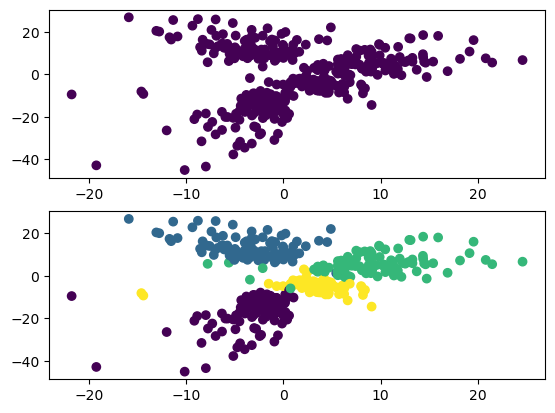

In [7]:
bbg = BBG(alpha=1.251, epsilon=0.05)
clusters = bbg.run(points, 4)
# graph points and color them according to their cluster
import matplotlib.pyplot as plt
figure, ax = plt.subplots(2)
ax[0].scatter(points[:, 0], points[:, 1], c=clusters)

plt.scatter(points[:, 0], points[:, 1], c=true_labels)
plt.show()

  1%|          | 55/4951 [00:00<00:09, 543.55it/s]

B, tau:  1.0000200000000001 0.0
B, tau:  1.0000200000000001 0.028400466184783757
B, tau:  1.0000200000000001 0.030359389759428514
B, tau:  1.0000200000000001 0.05680063536982382
B, tau:  1.0000200000000001 0.07643182534739619
B, tau:  1.0000200000000001 0.08007044513256688
B, tau:  1.0000200000000001 0.08035246210857423
B, tau:  1.0000200000000001 0.08436789478343444
B, tau:  1.0000200000000001 0.08649659672334599
B, tau:  1.0000200000000001 0.09645984144118419
B, tau:  1.0000200000000001 0.10857472077785296
B, tau:  1.0000200000000001 0.1189571414163511
B, tau:  1.0000200000000001 0.12025096294126034
B, tau:  1.0000200000000001 0.12337739451214949
B, tau:  1.0000200000000001 0.12346364979455915
B, tau:  1.0000200000000001 0.12560736153684782
B, tau:  1.0000200000000001 0.12590970811456811
B, tau:  1.0000200000000001 0.12685205538150504
B, tau:  1.0000200000000001 0.1294050997381708
B, tau:  1.0000200000000001 0.13264191518386836
B, tau:  1.0000200000000001 0.13672985376686783
B, tau: 

  3%|▎         | 166/4951 [00:00<00:09, 495.57it/s]

0.269348064000218
B, tau:  1.0000200000000001 0.27087836860939496
B, tau:  1.0000200000000001 0.2762855482609075
B, tau:  1.0000200000000001 0.2776456785893979
B, tau:  1.0000200000000001 0.2787785981123386
B, tau:  1.0000200000000001 0.27923221288798117
B, tau:  1.0000200000000001 0.2797770820604798
B, tau:  1.0000200000000001 0.2809155547818988
B, tau:  1.0000200000000001 0.2813585569527042
B, tau:  1.0000200000000001 0.2832858582143369
B, tau:  1.0000200000000001 0.2834596627311973
B, tau:  1.0000200000000001 0.2838962770118722
B, tau:  1.0000200000000001 0.28631598891126464
B, tau:  1.0000200000000001 0.28745769544154925
B, tau:  1.0000200000000001 0.28832619533128984
B, tau:  1.0000200000000001 0.28936358967862297
B, tau:  1.0000200000000001 0.28952033357586104
B, tau:  1.0000200000000001 0.2901997297519028
B, tau:  1.0000200000000001 0.2913241753264547
B, tau:  1.0000200000000001 0.29226112413830513
B, tau:  1.0000200000000001 0.2925044774327855
B, tau:  1.0000200000000001 0.2948

  5%|▌         | 272/4951 [00:00<00:09, 510.94it/s]

B, tau:  1.0000200000000001 0.3861134599541485
B, tau:  1.0000200000000001 0.38726865173718755
B, tau:  1.0000200000000001 0.38815341559478717
B, tau:  1.0000200000000001 0.38875632245027575
B, tau:  1.0000200000000001 0.3907804208979567
B, tau:  1.0000200000000001 0.39094567023499865
B, tau:  1.0000200000000001 0.3945450507740092
B, tau:  1.0000200000000001 0.39494080074773796
B, tau:  1.0000200000000001 0.3953645626344851
B, tau:  1.0000200000000001 0.39577699081620243
B, tau:  1.0000200000000001 0.39671696327063255
B, tau:  1.0000200000000001 0.40083162188824756
B, tau:  1.0000200000000001 0.40122925588230135
B, tau:  1.0000200000000001 0.4015704995986479
B, tau:  1.0000200000000001 0.4026127596394278
B, tau:  1.0000200000000001 0.4052490831753922
B, tau:  1.0000200000000001 0.4077396687013323
B, tau:  1.0000200000000001 0.40818658061031965
B, tau:  1.0000200000000001 0.40898743533810555
B, tau:  1.0000200000000001 0.4094631700842928
B, tau:  1.0000200000000001 0.41032670479989575
B

  7%|▋         | 324/4951 [00:00<00:09, 474.81it/s]

B, tau:  1.0000200000000001 0.49373585542874915
B, tau:  1.0000200000000001 0.49391641057047836
B, tau:  1.0000200000000001 0.49478383308960017
B, tau:  1.0000200000000001 0.49606185363306915
B, tau:  1.0000200000000001 0.4964252301457119
B, tau:  1.0000200000000001 0.4975023767442352
B, tau:  1.0000200000000001 0.49763821762747973
B, tau:  1.0000200000000001 0.4980676147733731
B, tau:  1.0000200000000001 0.49812775600790987
B, tau:  1.0000200000000001 0.49825958899441086
B, tau:  1.0000200000000001 0.4986958793168276
B, tau:  1.0000200000000001 0.4997985097592085
B, tau:  1.0000200000000001 0.5004720104912945
B, tau:  1.0000200000000001 0.5014259880471019
B, tau:  1.0000200000000001 0.5019722480689096
B, tau:  1.0000200000000001 0.5026422969843377
B, tau:  1.0000200000000001 0.503032030060605
B, tau:  1.0000200000000001 0.5033116345003181
B, tau:  1.0000200000000001 0.5046965943041876
B, tau:  1.0000200000000001 0.5048482021044118
B, tau:  1.0000200000000001 0.506509334456016
B, tau: 

  9%|▊         | 430/4951 [00:00<00:09, 501.79it/s]

B, tau:  1.0000200000000001 0.5666811576904011
B, tau:  1.0000200000000001 0.5671495882251375
B, tau:  1.0000200000000001 0.5674016702990792
B, tau:  1.0000200000000001 0.5682448247924833
B, tau:  1.0000200000000001 0.5686892468068635
B, tau:  1.0000200000000001 0.569182401189852
B, tau:  1.0000200000000001 0.5700617746780043
B, tau:  1.0000200000000001 0.5716215181349237
B, tau:  1.0000200000000001 0.5721595438218274
B, tau:  1.0000200000000001 0.5725368179545643
B, tau:  1.0000200000000001 0.5732229861336301
B, tau:  1.0000200000000001 0.5735194691958524
B, tau:  1.0000200000000001 0.5738253661325398
B, tau:  1.0000200000000001 0.5742640599288905
B, tau:  1.0000200000000001 0.5747721329796288
B, tau:  1.0000200000000001 0.5760860451283403
B, tau:  1.0000200000000001 0.5762788947578982
B, tau:  1.0000200000000001 0.5769561274205091
B, tau:  1.0000200000000001 0.5782907307241875
B, tau:  1.0000200000000001 0.5784107049295629
B, tau:  1.0000200000000001 0.5792665473770345
B, tau:  1.000

 11%|█         | 532/4951 [00:01<00:08, 501.67it/s]

B, tau:  1.0000200000000001 0.6365435041338047
B, tau:  1.0000200000000001 0.6367510855766485
B, tau:  1.0000200000000001 0.6371867821451662
B, tau:  1.0000200000000001 0.6377860535661775
B, tau:  1.0000200000000001 0.6381289274706621
B, tau:  1.0000200000000001 0.6384468008085368
B, tau:  1.0000200000000001 0.6395420936535481
B, tau:  1.0000200000000001 0.6407562760245188
B, tau:  1.0000200000000001 0.6428043994806626
B, tau:  1.0000200000000001 0.6437257082882539
B, tau:  1.0000200000000001 0.6447669016567424
B, tau:  1.0000200000000001 0.6448224134396112
B, tau:  1.0000200000000001 0.6456320909430717
B, tau:  1.0000200000000001 0.6460333747864162
B, tau:  1.0000200000000001 0.6462415576686203
B, tau:  1.0000200000000001 0.6466602945734947
B, tau:  1.0000200000000001 0.647163579112763
B, tau:  1.0000200000000001 0.6477273183883707
B, tau:  1.0000200000000001 0.6479420586678806
B, tau:  1.0000200000000001 0.648056564247318
B, tau:  1.0000200000000001 0.6489066867824691
B, tau:  1.0000

 13%|█▎        | 633/4951 [00:01<00:08, 491.68it/s]

B, tau:  1.0000200000000001 0.702305564216081
B, tau:  1.0000200000000001 0.7028198952353962
B, tau:  1.0000200000000001 0.7032042467966263
B, tau:  1.0000200000000001 0.704231839280872
B, tau:  1.0000200000000001 0.7044878469186016
B, tau:  1.0000200000000001 0.7059498888199022
B, tau:  1.0000200000000001 0.7061407463584153
B, tau:  1.0000200000000001 0.7064249131548693
B, tau:  1.0000200000000001 0.7066012330471666
B, tau:  1.0000200000000001 0.7078048762978398
B, tau:  1.0000200000000001 0.7087193733060683
B, tau:  1.0000200000000001 0.7091405943974867
B, tau:  1.0000200000000001 0.7100082038053984
B, tau:  1.0000200000000001 0.7104154136419819
B, tau:  1.0000200000000001 0.7118667538184975
B, tau:  1.0000200000000001 0.7133120438760476
B, tau:  1.0000200000000001 0.7135572084245703
B, tau:  1.0000200000000001 0.7137788210900993
B, tau:  1.0000200000000001 0.7139993648990683
B, tau:  1.0000200000000001 0.7141207099233948
B, tau:  1.0000200000000001 0.7165960195841115
B, tau:  1.0000

 15%|█▍        | 735/4951 [00:01<00:08, 489.07it/s]

B, tau:  1.0000200000000001 0.7593646500024376
B, tau:  1.0000200000000001 0.7594450670568439
B, tau:  1.0000200000000001 0.7604131977887024
B, tau:  1.0000200000000001 0.7622527573847139
B, tau:  1.0000200000000001 0.762485760696449
B, tau:  1.0000200000000001 0.7629947388304092
B, tau:  1.0000200000000001 0.7636914516919413
B, tau:  1.0000200000000001 0.7660554023899403
B, tau:  1.0000200000000001 0.7664415092513108
B, tau:  1.0000200000000001 0.7664423622487423
B, tau:  1.0000200000000001 0.7667642425102053
B, tau:  1.0000200000000001 0.7669917826923112
B, tau:  1.0000200000000001 0.7675384120306381
B, tau:  1.0000200000000001 0.7693203380221529
B, tau:  1.0000200000000001 0.7695978028952186
B, tau:  1.0000200000000001 0.7699065353614872
B, tau:  1.0000200000000001 0.7708945996898494
B, tau:  1.0000200000000001 0.7709690812342677
B, tau:  1.0000200000000001 0.7712269303143469
B, tau:  1.0000200000000001 0.7714086293956816
B, tau:  1.0000200000000001 0.7724586914259207
B, tau:  1.000

 16%|█▌        | 787/4951 [00:01<00:08, 498.09it/s]

B, tau:  1.0000200000000001 0.81289987809174
B, tau:  1.0000200000000001 0.8129518198340732
B, tau:  1.0000200000000001 0.8132083330142422
B, tau:  1.0000200000000001 0.8136114518317162
B, tau:  1.0000200000000001 0.813617174295937
B, tau:  1.0000200000000001 0.8165008284134488
B, tau:  1.0000200000000001 0.8165024000265436
B, tau:  1.0000200000000001 0.816691927017486
B, tau:  1.0000200000000001 0.8169674326934732
B, tau:  1.0000200000000001 0.8173346840355116
B, tau:  1.0000200000000001 0.8193133591540313
B, tau:  1.0000200000000001 0.8194236297249426
B, tau:  1.0000200000000001 0.8205357820052556
B, tau:  1.0000200000000001 0.8205422306250754
B, tau:  1.0000200000000001 0.8205512872152125
B, tau:  1.0000200000000001 0.8221319543750749
B, tau:  1.0000200000000001 0.8224869779366999
B, tau:  1.0000200000000001 0.823826535648007
B, tau:  1.0000200000000001 0.8251021526012652
B, tau:  1.0000200000000001 0.8251505643608331
B, tau:  1.0000200000000001 0.8260766042808835
B, tau:  1.0000200

 18%|█▊        | 887/4951 [00:01<00:08, 492.74it/s]

B, tau:  1.0000200000000001 0.8661464173711837
B, tau:  1.0000200000000001 0.8667593156780689
B, tau:  1.0000200000000001 0.8672260510657913
B, tau:  1.0000200000000001 0.8674916381729825
B, tau:  1.0000200000000001 0.867502405447754
B, tau:  1.0000200000000001 0.8675027703371812
B, tau:  1.0000200000000001 0.8675778708061413
B, tau:  1.0000200000000001 0.8679454102529822
B, tau:  1.0000200000000001 0.868665654634448
B, tau:  1.0000200000000001 0.8701732579482948
B, tau:  1.0000200000000001 0.8714531421438079
B, tau:  1.0000200000000001 0.871645348417652
B, tau:  1.0000200000000001 0.8720292765044118
B, tau:  1.0000200000000001 0.8720583628470001
B, tau:  1.0000200000000001 0.8732362092265623
B, tau:  1.0000200000000001 0.8737147623751217
B, tau:  1.0000200000000001 0.8739260986500003
B, tau:  1.0000200000000001 0.8741017353291564
B, tau:  1.0000200000000001 0.8752308119255582
B, tau:  1.0000200000000001 0.87524037582781
B, tau:  1.0000200000000001 0.8760618202565592
B, tau:  1.0000200

 20%|█▉        | 988/4951 [00:02<00:08, 493.48it/s]

B, tau:  1.0000200000000001 0.9090696356405633
B, tau:  1.0000200000000001 0.9093318087606623
B, tau:  1.0000200000000001 0.910333437474578
B, tau:  1.0000200000000001 0.9115254332537618
B, tau:  1.0000200000000001 0.9120308187519716
B, tau:  1.0000200000000001 0.9121518051806938
B, tau:  1.0000200000000001 0.9123122176690874
B, tau:  1.0000200000000001 0.9125129805133287
B, tau:  1.0000200000000001 0.9126172144945641
B, tau:  1.0000200000000001 0.9137786811680232
B, tau:  1.0000200000000001 0.9142726475343839
B, tau:  1.0000200000000001 0.9144468486582906
B, tau:  1.0000200000000001 0.915395022798407
B, tau:  1.0000200000000001 0.9155090262157612
B, tau:  1.0000200000000001 0.9159108973346939
B, tau:  1.0000200000000001 0.9177547740867025
B, tau:  1.0000200000000001 0.9187467968502273
B, tau:  1.0000200000000001 0.9188440936785133
B, tau:  1.0000200000000001 0.9188545058685689
B, tau:  1.0000200000000001 0.9195933804826014
B, tau:  1.0000200000000001 0.9196841093955922
B, tau:  1.0000

 22%|██▏       | 1090/4951 [00:02<00:07, 488.47it/s]

B, tau:  1.0000200000000001 0.9561048621455598
B, tau:  1.0000200000000001 0.956744535535428
B, tau:  1.0000200000000001 0.9578528014425213
B, tau:  1.0000200000000001 0.9579860067186009
B, tau:  1.0000200000000001 0.9581432796951964
B, tau:  1.0000200000000001 0.958211702713854
B, tau:  1.0000200000000001 0.9586665390076359
B, tau:  1.0000200000000001 0.9591400782779184
B, tau:  1.0000200000000001 0.9592697199142662
B, tau:  1.0000200000000001 0.9593712517285734
B, tau:  1.0000200000000001 0.959483973038518
B, tau:  1.0000200000000001 0.9595452410380576
B, tau:  1.0000200000000001 0.9596026688993838
B, tau:  1.0000200000000001 0.9596319862349308
B, tau:  1.0000200000000001 0.9597942865993103
B, tau:  1.0000200000000001 0.9601177912441864
B, tau:  1.0000200000000001 0.9608070986739129
B, tau:  1.0000200000000001 0.9611038327691257
B, tau:  1.0000200000000001 0.9612561176464474
B, tau:  1.0000200000000001 0.9622728569541951
B, tau:  1.0000200000000001 0.9623537065998986
B, tau:  1.00002

 24%|██▍       | 1192/4951 [00:02<00:07, 498.58it/s]

B, tau:  1.0000200000000001 1.0001573172122837
B, tau:  1.0000200000000001 1.000283997810995
B, tau:  1.0000200000000001 1.00054912301758
B, tau:  1.0000200000000001 1.001098171828693
B, tau:  1.0000200000000001 1.0013300417689148
B, tau:  1.0000200000000001 1.0014501661460664
B, tau:  1.0000200000000001 1.001965264821731
B, tau:  1.0000200000000001 1.0026175705214413
B, tau:  1.0000200000000001 1.0026253112279406
B, tau:  1.0000200000000001 1.003602242442034
B, tau:  1.0000200000000001 1.0042172205081739
B, tau:  1.0000200000000001 1.0044951351732418
B, tau:  1.0000200000000001 1.004674022325728
B, tau:  1.0000200000000001 1.0047514719755428
B, tau:  1.0000200000000001 1.0049772958484935
B, tau:  1.0000200000000001 1.0055089286846706
B, tau:  1.0000200000000001 1.0061591382565196
B, tau:  1.0000200000000001 1.0061614976816262
B, tau:  1.0000200000000001 1.0083684436937415
B, tau:  1.0000200000000001 1.0085811367344926
B, tau:  1.0000200000000001 1.0088971632633836
B, tau:  1.000020000

 26%|██▌       | 1292/4951 [00:02<00:07, 498.20it/s]

B, tau:  1.0000200000000001 1.0498758119360536
B, tau:  1.0000200000000001 1.0502185085608
B, tau:  1.0000200000000001 1.0506207414398576
B, tau:  1.0000200000000001 1.0508769592086726
B, tau:  1.0000200000000001 1.0512744047440308
B, tau:  1.0000200000000001 1.0513163506772802
B, tau:  1.0000200000000001 1.0519935457500236
B, tau:  1.0000200000000001 1.052248536259801
B, tau:  1.0000200000000001 1.0544648414487459
B, tau:  1.0000200000000001 1.0545747823186793
B, tau:  1.0000200000000001 1.0547463670248687
B, tau:  1.0000200000000001 1.0548175481047286
B, tau:  1.0000200000000001 1.0549318764631355
B, tau:  1.0000200000000001 1.0550556585416726
B, tau:  1.0000200000000001 1.055271575183819
B, tau:  1.0000200000000001 1.0554709467634866
B, tau:  1.0000200000000001 1.0570324902564614
B, tau:  1.0000200000000001 1.0571592441510158
B, tau:  1.0000200000000001 1.0578870862509393
B, tau:  1.0000200000000001 1.0587334888452673
B, tau:  1.0000200000000001 1.0590334043733298
B, tau:  1.0000200

 27%|██▋       | 1346/4951 [00:02<00:07, 509.19it/s]

B, tau:  1.0000200000000001 1.0982559437370525
B, tau:  1.0000200000000001 1.100041958179315
B, tau:  1.0000200000000001 1.1000424745629294
B, tau:  1.0000200000000001 1.1007913639046205
B, tau:  1.0000200000000001 1.101666159421435
B, tau:  1.0000200000000001 1.1018741105482976
B, tau:  1.0000200000000001 1.10254250572516
B, tau:  1.0000200000000001 1.102825364133245
B, tau:  1.0000200000000001 1.1035196085102126
B, tau:  1.0000200000000001 1.1036140298191262
B, tau:  1.0000200000000001 1.1046524501162858
B, tau:  1.0000200000000001 1.1048883571573138
B, tau:  1.0000200000000001 1.1049564602187405
B, tau:  1.0000200000000001 1.1064888836460907
B, tau:  1.0000200000000001 1.106548302186938
B, tau:  1.0000200000000001 1.1072016484732443
B, tau:  1.0000200000000001 1.1072696565392728
B, tau:  1.0000200000000001 1.107374326130689
B, tau:  1.0000200000000001 1.1076081629886425
B, tau:  1.0000200000000001 1.1076811461039446
B, tau:  1.0000200000000001 1.1077856066606617
B, tau:  1.000020000

 29%|██▉       | 1455/4951 [00:02<00:06, 524.95it/s]

1.0000200000000001 1.1518226026103189
B, tau:  1.0000200000000001 1.1520799781384665
B, tau:  1.0000200000000001 1.1526932958900997
B, tau:  1.0000200000000001 1.1527446943362367
B, tau:  1.0000200000000001 1.1538301690134531
B, tau:  1.0000200000000001 1.1543866440337374
B, tau:  1.0000200000000001 1.154811057379562
B, tau:  1.0000200000000001 1.1549833601580373
B, tau:  1.0000200000000001 1.157776539944981
B, tau:  1.0000200000000001 1.1582112946918395
B, tau:  1.0000200000000001 1.1587453597678938
B, tau:  1.0000200000000001 1.1588971703859638
B, tau:  1.0000200000000001 1.15899452279031
B, tau:  1.0000200000000001 1.1605545541889237
B, tau:  1.0000200000000001 1.1608794388991277
B, tau:  1.0000200000000001 1.1610667270720583
B, tau:  1.0000200000000001 1.1614159806597468
B, tau:  1.0000200000000001 1.1619746021192332
B, tau:  1.0000200000000001 1.1620790621512307
B, tau:  1.0000200000000001 1.162095872956634
B, tau:  1.0000200000000001 1.1621949587902167
B, tau:  1.0000200000000001

 32%|███▏      | 1566/4951 [00:03<00:06, 508.52it/s]

B, tau:  1.0000200000000001 1.2078815022150353
B, tau:  1.0000200000000001 1.2082026019571328
B, tau:  1.0000200000000001 1.2084012011987897
B, tau:  1.0000200000000001 1.2086209580471687
B, tau:  1.0000200000000001 1.2087819644993893
B, tau:  1.0000200000000001 1.209936252772385
B, tau:  1.0000200000000001 1.2100732776817873
B, tau:  1.0000200000000001 1.2100813825968784
B, tau:  1.0000200000000001 1.2106194494481817
B, tau:  1.0000200000000001 1.2113268509296142
B, tau:  1.0000200000000001 1.2113345724281548
B, tau:  1.0000200000000001 1.211944369977701
B, tau:  1.0000200000000001 1.2119787052126034
B, tau:  1.0000200000000001 1.212034989738488
B, tau:  1.0000200000000001 1.2125623396542826
B, tau:  1.0000200000000001 1.2125908546413422
B, tau:  1.0000200000000001 1.2130277036897985
B, tau:  1.0000200000000001 1.2138950928817878
B, tau:  1.0000200000000001 1.2167108337629984
B, tau:  1.0000200000000001 1.216755066162543
B, tau:  1.0000200000000001 1.2169335063884552
B, tau:  1.000020

 34%|███▎      | 1668/4951 [00:03<00:06, 495.62it/s]

B, tau:  1.0000200000000001 1.2548450292375268
B, tau:  1.0000200000000001 1.2549198693619403
B, tau:  1.0000200000000001 1.2552508509487375
B, tau:  1.0000200000000001 1.2556074608058587
B, tau:  1.0000200000000001 1.2556818235382619
B, tau:  1.0000200000000001 1.256331117276723
B, tau:  1.0000200000000001 1.2575062439198965
B, tau:  1.0000200000000001 1.2576241110334085
B, tau:  1.0000200000000001 1.2579705311150744
B, tau:  1.0000200000000001 1.2583343584385198
B, tau:  1.0000200000000001 1.2591992003120611
B, tau:  1.0000200000000001 1.2592060490703665
B, tau:  1.0000200000000001 1.2592249400155135
B, tau:  1.0000200000000001 1.259424870443235
B, tau:  1.0000200000000001 1.259880089944181
B, tau:  1.0000200000000001 1.2609488196972107
B, tau:  1.0000200000000001 1.2612188294189086
B, tau:  1.0000200000000001 1.2613519929802839
B, tau:  1.0000200000000001 1.26219893514957
B, tau:  1.0000200000000001 1.26237403245285
B, tau:  1.0000200000000001 1.2625990192008045
B, tau:  1.000020000

 35%|███▍      | 1718/4951 [00:03<00:06, 484.11it/s]

B, tau:  1.0000200000000001 1.2948438846043338
B, tau:  1.0000200000000001 1.2966132396776835
B, tau:  1.0000200000000001 1.298579913446124
B, tau:  1.0000200000000001 1.2987071585891725
B, tau:  1.0000200000000001 1.2990727589265012
B, tau:  1.0000200000000001 1.2994269458753667
B, tau:  1.0000200000000001 1.300701370760613
B, tau:  1.0000200000000001 1.3012247130825934
B, tau:  1.0000200000000001 1.3025505559630834
B, tau:  1.0000200000000001 1.3030704962094408
B, tau:  1.0000200000000001 1.303098240208178
B, tau:  1.0000200000000001 1.3031047682396253
B, tau:  1.0000200000000001 1.3032062136298912
B, tau:  1.0000200000000001 1.3035632085418682
B, tau:  1.0000200000000001 1.3051997133606041
B, tau:  1.0000200000000001 1.3054109763384774
B, tau:  1.0000200000000001 1.306408539360295
B, tau:  1.0000200000000001 1.3064682764076563
B, tau:  1.0000200000000001 1.3067627667868447
B, tau:  1.0000200000000001 1.3071643242214328
B, tau:  1.0000200000000001 1.307289135408285
B, tau:  1.0000200

 37%|███▋      | 1819/4951 [00:03<00:06, 489.40it/s]

B, tau:  1.0000200000000001 1.3342110468329949
B, tau:  1.0000200000000001 1.3347875724490836
B, tau:  1.0000200000000001 1.3350292953783158
B, tau:  1.0000200000000001 1.3353641753668977
B, tau:  1.0000200000000001 1.3357568229975645
B, tau:  1.0000200000000001 1.3363350055594223
B, tau:  1.0000200000000001 1.3366342033167022
B, tau:  1.0000200000000001 1.3368541692139833
B, tau:  1.0000200000000001 1.3371179966920095
B, tau:  1.0000200000000001 1.339432743299602
B, tau:  1.0000200000000001 1.3406361405348384
B, tau:  1.0000200000000001 1.3406677270612262
B, tau:  1.0000200000000001 1.3409660401842258
B, tau:  1.0000200000000001 1.341226783495632
B, tau:  1.0000200000000001 1.3412343993456202
B, tau:  1.0000200000000001 1.3429257522469884
B, tau:  1.0000200000000001 1.3434479055034938
B, tau:  1.0000200000000001 1.34375175925115
B, tau:  1.0000200000000001 1.3438409288083462
B, tau:  1.0000200000000001 1.3438743002052327
B, tau:  1.0000200000000001 1.3440664438798828
B, tau:  1.000020

 39%|███▉      | 1919/4951 [00:03<00:06, 487.43it/s]

B, tau:  1.0000200000000001 1.3740815107467517
B, tau:  1.0000200000000001 1.3745687367197734
B, tau:  1.0000200000000001 1.3748171865774963
B, tau:  1.0000200000000001 1.3748283752878019
B, tau:  1.0000200000000001 1.3749319643155036
B, tau:  1.0000200000000001 1.3750155606281642
B, tau:  1.0000200000000001 1.3750932388513648
B, tau:  1.0000200000000001 1.3761292245409324
B, tau:  1.0000200000000001 1.3765632678415458
B, tau:  1.0000200000000001 1.37692574231791
B, tau:  1.0000200000000001 1.377055524143941
B, tau:  1.0000200000000001 1.3771730306176115
B, tau:  1.0000200000000001 1.3774069232704236
B, tau:  1.0000200000000001 1.3781523242992666
B, tau:  1.0000200000000001 1.3787119672900423
B, tau:  1.0000200000000001 1.3787943328731633
B, tau:  1.0000200000000001 1.3790575144788362
B, tau:  1.0000200000000001 1.3798292890210302
B, tau:  1.0000200000000001 1.3800827420443855
B, tau:  1.0000200000000001 1.380089688968966
B, tau:  1.0000200000000001 1.3803180456218642
B, tau:  1.000020

 41%|████      | 2025/4951 [00:04<00:05, 506.96it/s]

1.0000200000000001 1.420965658668968
B, tau:  1.0000200000000001 1.4210397181393157
B, tau:  1.0000200000000001 1.4215076333261711
B, tau:  1.0000200000000001 1.4217722555061305
B, tau:  1.0000200000000001 1.4217872805260054
B, tau:  1.0000200000000001 1.4221346110493325
B, tau:  1.0000200000000001 1.422211776156459
B, tau:  1.0000200000000001 1.422328395741769
B, tau:  1.0000200000000001 1.4224353636583018
B, tau:  1.0000200000000001 1.423686526493984
B, tau:  1.0000200000000001 1.423840439420021
B, tau:  1.0000200000000001 1.4239271321437899
B, tau:  1.0000200000000001 1.424116878409502
B, tau:  1.0000200000000001 1.4243224318327603
B, tau:  1.0000200000000001 1.425108410392539
B, tau:  1.0000200000000001 1.425626903535826
B, tau:  1.0000200000000001 1.4258033732922697
B, tau:  1.0000200000000001 1.4263081204509158
B, tau:  1.0000200000000001 1.4267731838805808
B, tau:  1.0000200000000001 1.4274464899795969
B, tau:  1.0000200000000001 1.4277824132811805
B, tau:  1.0000200000000001 1.

 42%|████▏     | 2076/4951 [00:04<00:05, 484.45it/s]

B, tau:  1.0000200000000001 1.4726725886559011
B, tau:  1.0000200000000001 1.4727903243011302
B, tau:  1.0000200000000001 1.4730915940653861
B, tau:  1.0000200000000001 1.4731176159567456
B, tau:  1.0000200000000001 1.4731416212471675
B, tau:  1.0000200000000001 1.4738918250313848
B, tau:  1.0000200000000001 1.4748779624766553
B, tau:  1.0000200000000001 1.474920356060624
B, tau:  1.0000200000000001 1.4750168764022065
B, tau:  1.0000200000000001 1.4758264613279657
B, tau:  1.0000200000000001 1.4762548367303754
B, tau:  1.0000200000000001 1.476961053085432
B, tau:  1.0000200000000001 1.4777536132995197
B, tau:  1.0000200000000001 1.4782881171380444
B, tau:  1.0000200000000001 1.478447366232518
B, tau:  1.0000200000000001 1.478596300088506
B, tau:  1.0000200000000001 1.4792095211629555
B, tau:  1.0000200000000001 1.479689674409392
B, tau:  1.0000200000000001 1.4798214601651083
B, tau:  1.0000200000000001 1.4798908499405243
B, tau:  1.0000200000000001 1.4800094072121242
B, tau:  1.0000200

 44%|████▍     | 2174/4951 [00:04<00:06, 462.41it/s]

B, tau:  1.0000200000000001 1.4998874025190656
B, tau:  1.0000200000000001 1.5003904664762895
B, tau:  1.0000200000000001 1.5006034938287478
B, tau:  1.0000200000000001 1.500779288449355
B, tau:  1.0000200000000001 1.5008083965959766
B, tau:  1.0000200000000001 1.5010883375562984
B, tau:  1.0000200000000001 1.5012071506610982
B, tau:  1.0000200000000001 1.501446022484543
B, tau:  1.0000200000000001 1.5024194334113874
B, tau:  1.0000200000000001 1.5024399586914892
B, tau:  1.0000200000000001 1.502634915321628
B, tau:  1.0000200000000001 1.503197059457381
B, tau:  1.0000200000000001 1.5035518162589179
B, tau:  1.0000200000000001 1.5036110913222132
B, tau:  1.0000200000000001 1.503737162704385
B, tau:  1.0000200000000001 1.5045945497970776
B, tau:  1.0000200000000001 1.5048099551914174
B, tau:  1.0000200000000001 1.504992283773645
B, tau:  1.0000200000000001 1.5052379691759024
B, tau:  1.0000200000000001 1.506277704968727
B, tau:  1.0000200000000001 1.5066824136051382
B, tau:  1.000020000

 46%|████▌     | 2278/4951 [00:04<00:05, 485.79it/s]

B, tau:  1.0000200000000001 1.5387973223676488
B, tau:  1.0000200000000001 1.5391358262863808
B, tau:  1.0000200000000001 1.54122684621039
B, tau:  1.0000200000000001 1.541856436772398
B, tau:  1.0000200000000001 1.5421928070455801
B, tau:  1.0000200000000001 1.5422095217328824
B, tau:  1.0000200000000001 1.5444397994443495
B, tau:  1.0000200000000001 1.545242956543284
B, tau:  1.0000200000000001 1.5452939193959527
B, tau:  1.0000200000000001 1.5457479836171124
B, tau:  1.0000200000000001 1.546851966446713
B, tau:  1.0000200000000001 1.5470171948596034
B, tau:  1.0000200000000001 1.5476626143022896
B, tau:  1.0000200000000001 1.5476795136886825
B, tau:  1.0000200000000001 1.5477805672421672
B, tau:  1.0000200000000001 1.5482991413107823
B, tau:  1.0000200000000001 1.548679049390776
B, tau:  1.0000200000000001 1.5487304758746665
B, tau:  1.0000200000000001 1.5488593803653823
B, tau:  1.0000200000000001 1.5495694859337368
B, tau:  1.0000200000000001 1.5499866584183062
B, tau:  1.00002000

 48%|████▊     | 2381/4951 [00:04<00:05, 500.08it/s]

B, tau:  1.0000200000000001 1.5865851934295634
B, tau:  1.0000200000000001 1.5868813876357926
B, tau:  1.0000200000000001 1.5871017953303916
B, tau:  1.0000200000000001 1.5876758483615574
B, tau:  1.0000200000000001 1.5877835913366944
B, tau:  1.0000200000000001 1.5880464499455857
B, tau:  1.0000200000000001 1.5882676522383676
B, tau:  1.0000200000000001 1.5892378593503065
B, tau:  1.0000200000000001 1.5899182146204178
B, tau:  1.0000200000000001 1.5900251255134317
B, tau:  1.0000200000000001 1.5900907204707748
B, tau:  1.0000200000000001 1.5903222601995173
B, tau:  1.0000200000000001 1.5907711515364407
B, tau:  1.0000200000000001 1.5908085626825672
B, tau:  1.0000200000000001 1.5912968490506216
B, tau:  1.0000200000000001 1.591350992249307
B, tau:  1.0000200000000001 1.5917106759954869
B, tau:  1.0000200000000001 1.5917572248871923
B, tau:  1.0000200000000001 1.5918371760346823
B, tau:  1.0000200000000001 1.5919894171912519
B, tau:  1.0000200000000001 1.5924429319981874
B, tau:  1.000

 50%|█████     | 2482/4951 [00:05<00:05, 491.28it/s]

B, tau:  1.0000200000000001 1.626838574683747
B, tau:  1.0000200000000001 1.6268499957179638
B, tau:  1.0000200000000001 1.6268702436153113
B, tau:  1.0000200000000001 1.6276681891430587
B, tau:  1.0000200000000001 1.6277281695833352
B, tau:  1.0000200000000001 1.6277749331278344
B, tau:  1.0000200000000001 1.6278127031901184
B, tau:  1.0000200000000001 1.6283611443588795
B, tau:  1.0000200000000001 1.6284279465976017
B, tau:  1.0000200000000001 1.6284997458721215
B, tau:  1.0000200000000001 1.6297927126961227
B, tau:  1.0000200000000001 1.6298700243136865
B, tau:  1.0000200000000001 1.6299181830099982
B, tau:  1.0000200000000001 1.630497759514524
B, tau:  1.0000200000000001 1.6309249959232903
B, tau:  1.0000200000000001 1.6313790056998196
B, tau:  1.0000200000000001 1.632335126169956
B, tau:  1.0000200000000001 1.6331964682572548
B, tau:  1.0000200000000001 1.6333368655949143
B, tau:  1.0000200000000001 1.6345148659458364
B, tau:  1.0000200000000001 1.635156958727181
B, tau:  1.000020

 52%|█████▏    | 2582/4951 [00:05<00:04, 483.66it/s]

B, tau:  1.0000200000000001 1.6642509728550556
B, tau:  1.0000200000000001 1.664955423752862
B, tau:  1.0000200000000001 1.6653305275917367
B, tau:  1.0000200000000001 1.6667193269783687
B, tau:  1.0000200000000001 1.667213214704449
B, tau:  1.0000200000000001 1.66768847827863
B, tau:  1.0000200000000001 1.6680549956971447
B, tau:  1.0000200000000001 1.668290088657902
B, tau:  1.0000200000000001 1.6684275908915482
B, tau:  1.0000200000000001 1.6689418172545099
B, tau:  1.0000200000000001 1.6693348004675992
B, tau:  1.0000200000000001 1.6693809136366673
B, tau:  1.0000200000000001 1.670553762233705
B, tau:  1.0000200000000001 1.6707774575610144
B, tau:  1.0000200000000001 1.6710256885825332
B, tau:  1.0000200000000001 1.6712878647194405
B, tau:  1.0000200000000001 1.6715584310772456
B, tau:  1.0000200000000001 1.6717357888142714
B, tau:  1.0000200000000001 1.672235806913927
B, tau:  1.0000200000000001 1.6723582766601337
B, tau:  1.0000200000000001 1.672715819061382
B, tau:  1.0000200000

 53%|█████▎    | 2631/4951 [00:05<00:04, 483.75it/s]

B, tau:  1.0000200000000001 1.7000113029654338
B, tau:  1.0000200000000001 1.700057811586221
B, tau:  1.0000200000000001 1.7001240798081647
B, tau:  1.0000200000000001 1.7002189923587019
B, tau:  1.0000200000000001 1.70154769727634
B, tau:  1.0000200000000001 1.701628323922813
B, tau:  1.0000200000000001 1.701674370037413
B, tau:  1.0000200000000001 1.7019307584309291
B, tau:  1.0000200000000001 1.7020902151537063
B, tau:  1.0000200000000001 1.702200114266429
B, tau:  1.0000200000000001 1.7024281808385455
B, tau:  1.0000200000000001 1.702738372187036
B, tau:  1.0000200000000001 1.70341382980313
B, tau:  1.0000200000000001 1.7036888497911045
B, tau:  1.0000200000000001 1.7038416631673228
B, tau:  1.0000200000000001 1.7039713046141212
B, tau:  1.0000200000000001 1.7042165162149163
B, tau:  1.0000200000000001 1.7048467552764444
B, tau:  1.0000200000000001 1.705006630517493
B, tau:  1.0000200000000001 1.705536409985422
B, tau:  1.0000200000000001 1.7057177233694931
B, tau:  1.0000200000000

 55%|█████▌    | 2730/4951 [00:05<00:05, 443.42it/s]

B, tau:  1.0000200000000001 1.7380292360421041
B, tau:  1.0000200000000001 1.738041964194946
B, tau:  1.0000200000000001 1.7382884447146412
B, tau:  1.0000200000000001 1.7386535931964882
B, tau:  1.0000200000000001 1.7387413582242055
B, tau:  1.0000200000000001 1.738855908602125
B, tau:  1.0000200000000001 1.7392601962849346
B, tau:  1.0000200000000001 1.740086753553453
B, tau:  1.0000200000000001 1.7403690577427722
B, tau:  1.0000200000000001 1.7404288787666315
B, tau:  1.0000200000000001 1.741394893091105
B, tau:  1.0000200000000001 1.7417125959325543
B, tau:  1.0000200000000001 1.7420178495165126
B, tau:  1.0000200000000001 1.7449034128099148
B, tau:  1.0000200000000001 1.7455428632601897
B, tau:  1.0000200000000001 1.745566366809337
B, tau:  1.0000200000000001 1.7456811380749209
B, tau:  1.0000200000000001 1.7471811579857692
B, tau:  1.0000200000000001 1.7475589440582047
B, tau:  1.0000200000000001 1.7476564566387176
B, tau:  1.0000200000000001 1.7480419975330121
B, tau:  1.0000200

 57%|█████▋    | 2822/4951 [00:05<00:04, 445.28it/s]

1.775551846500426
B, tau:  1.0000200000000001 1.7757294046107233
B, tau:  1.0000200000000001 1.7760757635946065
B, tau:  1.0000200000000001 1.7763495314766224
B, tau:  1.0000200000000001 1.7767929919946972
B, tau:  1.0000200000000001 1.7772942432260048
B, tau:  1.0000200000000001 1.7775581526765813
B, tau:  1.0000200000000001 1.7778297604491655
B, tau:  1.0000200000000001 1.778293845031578
B, tau:  1.0000200000000001 1.778634403443436
B, tau:  1.0000200000000001 1.7791026720739316
B, tau:  1.0000200000000001 1.780969867152173
B, tau:  1.0000200000000001 1.7814054383654279
B, tau:  1.0000200000000001 1.7814790363711472
B, tau:  1.0000200000000001 1.7824205469319943
B, tau:  1.0000200000000001 1.7833302419519432
B, tau:  1.0000200000000001 1.7842344690570207
B, tau:  1.0000200000000001 1.7855577539279952
B, tau:  1.0000200000000001 1.7856253341755117
B, tau:  1.0000200000000001 1.787450420959089
B, tau:  1.0000200000000001 1.7876709623254854
B, tau:  1.0000200000000001 1.7882100887874282

 59%|█████▉    | 2920/4951 [00:05<00:04, 461.75it/s]

B, tau:  1.0000200000000001 1.8207224552391414
B, tau:  1.0000200000000001 1.8209319195492506
B, tau:  1.0000200000000001 1.820982166272742
B, tau:  1.0000200000000001 1.8210855134793116
B, tau:  1.0000200000000001 1.8225546718528298
B, tau:  1.0000200000000001 1.8233681310583567
B, tau:  1.0000200000000001 1.8234457148678693
B, tau:  1.0000200000000001 1.8235152637591512
B, tau:  1.0000200000000001 1.8236387641337772
B, tau:  1.0000200000000001 1.8236475929272093
B, tau:  1.0000200000000001 1.823685585050573
B, tau:  1.0000200000000001 1.823707274593997
B, tau:  1.0000200000000001 1.8245133201795858
B, tau:  1.0000200000000001 1.8251645985066656
B, tau:  1.0000200000000001 1.826730339214557
B, tau:  1.0000200000000001 1.826856643681973
B, tau:  1.0000200000000001 1.8273102848400185
B, tau:  1.0000200000000001 1.82749718439364
B, tau:  1.0000200000000001 1.8278128277828842
B, tau:  1.0000200000000001 1.8278659507676613
B, tau:  1.0000200000000001 1.8278920705914328
B, tau:  1.000020000

 60%|█████▉    | 2970/4951 [00:06<00:04, 472.55it/s]

B, tau:  1.0000200000000001 1.8632613254304518
B, tau:  1.0000200000000001 1.8638873653762569
B, tau:  1.0000200000000001 1.8642571133210888
B, tau:  1.0000200000000001 1.864426511907399
B, tau:  1.0000200000000001 1.8645434093421465
B, tau:  1.0000200000000001 1.8645762098426117
B, tau:  1.0000200000000001 1.8649529197801957
B, tau:  1.0000200000000001 1.865161874763929
B, tau:  1.0000200000000001 1.8651845366030597
B, tau:  1.0000200000000001 1.8653510767599242
B, tau:  1.0000200000000001 1.8675259888807343
B, tau:  1.0000200000000001 1.8679556551818448
B, tau:  1.0000200000000001 1.8686795180901044
B, tau:  1.0000200000000001 1.8693811453823472
B, tau:  1.0000200000000001 1.86968881369946
B, tau:  1.0000200000000001 1.8697280961639045
B, tau:  1.0000200000000001 1.8706975503631338
B, tau:  1.0000200000000001 1.8711957409253421
B, tau:  1.0000200000000001 1.871278485517059
B, tau:  1.0000200000000001 1.8714597105450679
B, tau:  1.0000200000000001 1.8722354871397524
B, tau:  1.0000200

 62%|██████▏   | 3068/4951 [00:06<00:03, 476.43it/s]

B, tau:  1.0000200000000001 1.909031829025841
B, tau:  1.0000200000000001 1.9091068227534256
B, tau:  1.0000200000000001 1.9092803483989869
B, tau:  1.0000200000000001 1.9093917434320524
B, tau:  1.0000200000000001 1.9102329860652
B, tau:  1.0000200000000001 1.911070579231491
B, tau:  1.0000200000000001 1.911122565133959
B, tau:  1.0000200000000001 1.9122184019006023
B, tau:  1.0000200000000001 1.913532976659266
B, tau:  1.0000200000000001 1.913933661350485
B, tau:  1.0000200000000001 1.9140500450708349
B, tau:  1.0000200000000001 1.9147153672153348
B, tau:  1.0000200000000001 1.9152253430522588
B, tau:  1.0000200000000001 1.9156011375881294
B, tau:  1.0000200000000001 1.9157539925143168
B, tau:  1.0000200000000001 1.9159018351188273
B, tau:  1.0000200000000001 1.9164149634006515
B, tau:  1.0000200000000001 1.9164802679313238
B, tau:  1.0000200000000001 1.9167698121168957
B, tau:  1.0000200000000001 1.917176196333058
B, tau:  1.0000200000000001 1.917928565620139
B, tau:  1.000020000000

 64%|██████▍   | 3171/4951 [00:06<00:03, 485.74it/s]

B, tau:  1.0000200000000001 1.9527694832623637
B, tau:  1.0000200000000001 1.9529845068812852
B, tau:  1.0000200000000001 1.9533200787070855
B, tau:  1.0000200000000001 1.9533316362485225
B, tau:  1.0000200000000001 1.9536587262519964
B, tau:  1.0000200000000001 1.9539041203879841
B, tau:  1.0000200000000001 1.9539371985842735
B, tau:  1.0000200000000001 1.9543446544196819
B, tau:  1.0000200000000001 1.9543623463758977
B, tau:  1.0000200000000001 1.9551476975871254
B, tau:  1.0000200000000001 1.9552999312940011
B, tau:  1.0000200000000001 1.9561413005681383
B, tau:  1.0000200000000001 1.9569357796176345
B, tau:  1.0000200000000001 1.9571103349785062
B, tau:  1.0000200000000001 1.9571269086696512
B, tau:  1.0000200000000001 1.9572601776591299
B, tau:  1.0000200000000001 1.9574217218339023
B, tau:  1.0000200000000001 1.9579437144621596
B, tau:  1.0000200000000001 1.9589620854075027
B, tau:  1.0000200000000001 1.959053238667867
B, tau:  1.0000200000000001 1.9594714871927195
B, tau:  1.000

 66%|██████▌   | 3274/4951 [00:06<00:03, 495.15it/s]

B, tau:  1.0000200000000001 1.9983765344485054
B, tau:  1.0000200000000001 1.9995629014293643
B, tau:  1.0000200000000001 1.9998247988122986
B, tau:  1.0000200000000001 2.000067617240161
B, tau:  1.0000200000000001 2.000623015020411
B, tau:  1.0000200000000001 2.001062301991519
B, tau:  1.0000200000000001 2.0019484781495502
B, tau:  1.0000200000000001 2.002690253123846
B, tau:  1.0000200000000001 2.005451218266716
B, tau:  1.0000200000000001 2.005478973404601
B, tau:  1.0000200000000001 2.0055401286865195
B, tau:  1.0000200000000001 2.0060630461898263
B, tau:  1.0000200000000001 2.006199606844377
B, tau:  1.0000200000000001 2.0077383980005146
B, tau:  1.0000200000000001 2.00786466910337
B, tau:  1.0000200000000001 2.0084305964928
B, tau:  1.0000200000000001 2.008498365003341
B, tau:  1.0000200000000001 2.008557421819044
B, tau:  1.0000200000000001 2.0086410970746247
B, tau:  1.0000200000000001 2.0106363841403714
B, tau:  1.0000200000000001 2.010747928236605
B, tau:  1.0000200000000001 

 68%|██████▊   | 3374/4951 [00:06<00:03, 488.94it/s]

B, tau:  1.0000200000000001 2.0543668633610332
B, tau:  1.0000200000000001 2.054413931399181
B, tau:  1.0000200000000001 2.05544070716756
B, tau:  1.0000200000000001 2.055649734491331
B, tau:  1.0000200000000001 2.056087145475512
B, tau:  1.0000200000000001 2.0566125172990883
B, tau:  1.0000200000000001 2.057026962575228
B, tau:  1.0000200000000001 2.058370140466571
B, tau:  1.0000200000000001 2.059906875434659
B, tau:  1.0000200000000001 2.060402581203195
B, tau:  1.0000200000000001 2.060996010738372
B, tau:  1.0000200000000001 2.0609976872318923
B, tau:  1.0000200000000001 2.0610645785126405
B, tau:  1.0000200000000001 2.0614118646459128
B, tau:  1.0000200000000001 2.061550032193098
B, tau:  1.0000200000000001 2.0620275477246706
B, tau:  1.0000200000000001 2.0621200017415124
B, tau:  1.0000200000000001 2.062124414154114
B, tau:  1.0000200000000001 2.0623770321433486
B, tau:  1.0000200000000001 2.062642627633769
B, tau:  1.0000200000000001 2.062670245435499
B, tau:  1.0000200000000001

 69%|██████▉   | 3423/4951 [00:07<00:03, 485.80it/s]

B, tau:  1.0000200000000001 2.101027612250177
B, tau:  1.0000200000000001 2.1026636949544364
B, tau:  1.0000200000000001 2.103197737762097
B, tau:  1.0000200000000001 2.103355452155998
B, tau:  1.0000200000000001 2.1040329566540605
B, tau:  1.0000200000000001 2.1042456344709524
B, tau:  1.0000200000000001 2.104566180026469
B, tau:  1.0000200000000001 2.1054004383526803
B, tau:  1.0000200000000001 2.1058962640788477
B, tau:  1.0000200000000001 2.1065620417302133
B, tau:  1.0000200000000001 2.107440765899978
B, tau:  1.0000200000000001 2.1076408663492687
B, tau:  1.0000200000000001 2.108348206849531
B, tau:  1.0000200000000001 2.1100497442385664
B, tau:  1.0000200000000001 2.1101981509694525
B, tau:  1.0000200000000001 2.1108175218730048
B, tau:  1.0000200000000001 2.11360548497424
B, tau:  1.0000200000000001 2.113839364402131
B, tau:  1.0000200000000001 2.1150661831234867
B, tau:  1.0000200000000001 2.115433696835704
B, tau:  1.0000200000000001 2.116171414530936
B, tau:  1.0000200000000

 71%|███████   | 3526/4951 [00:07<00:03, 467.01it/s]

B, tau:  1.0000200000000001 2.155412024860441
B, tau:  1.0000200000000001 2.1555021317335554
B, tau:  1.0000200000000001 2.1564342300055306
B, tau:  1.0000200000000001 2.156442598003732
B, tau:  1.0000200000000001 2.156688315753375
B, tau:  1.0000200000000001 2.157190519674334
B, tau:  1.0000200000000001 2.157899205930565
B, tau:  1.0000200000000001 2.1580323995141666
B, tau:  1.0000200000000001 2.1586195525729317
B, tau:  1.0000200000000001 2.1590100580740637
B, tau:  1.0000200000000001 2.1591650636184245
B, tau:  1.0000200000000001 2.159664333059899
B, tau:  1.0000200000000001 2.1605503811881928
B, tau:  1.0000200000000001 2.1621247012095854
B, tau:  1.0000200000000001 2.1623106233419276
B, tau:  1.0000200000000001 2.162337162704546
B, tau:  1.0000200000000001 2.1631789952892837
B, tau:  1.0000200000000001 2.1640695933686014
B, tau:  1.0000200000000001 2.164099704231914
B, tau:  1.0000200000000001 2.164306867068361
B, tau:  1.0000200000000001 2.164337214893037
B, tau:  1.000020000000

 73%|███████▎  | 3623/4951 [00:07<00:02, 458.73it/s]

B, tau:  1.0000200000000001 2.1961306091193
B, tau:  1.0000200000000001 2.196989942320503
B, tau:  1.0000200000000001 2.197271344274172
B, tau:  1.0000200000000001 2.20037730169317
B, tau:  1.0000200000000001 2.2004377291970774
B, tau:  1.0000200000000001 2.2006355451940176
B, tau:  1.0000200000000001 2.2012548262965916
B, tau:  1.0000200000000001 2.201531056460002
B, tau:  1.0000200000000001 2.201559103393097
B, tau:  1.0000200000000001 2.2024049342161978
B, tau:  1.0000200000000001 2.2030015459748546
B, tau:  1.0000200000000001 2.2033571557171356
B, tau:  1.0000200000000001 2.2049402215035343
B, tau:  1.0000200000000001 2.2050153453411467
B, tau:  1.0000200000000001 2.2051593232697146
B, tau:  1.0000200000000001 2.2061477072947775
B, tau:  1.0000200000000001 2.206344639548517
B, tau:  1.0000200000000001 2.206681412129439
B, tau:  1.0000200000000001 2.2067203262867423
B, tau:  1.0000200000000001 2.2070667747498445
B, tau:  1.0000200000000001 2.2072642155601163
B, tau:  1.0000200000000

 75%|███████▌  | 3717/4951 [00:07<00:02, 440.74it/s]

B, tau:  1.0000200000000001 2.246179985517124
B, tau:  1.0000200000000001 2.246246200564664
B, tau:  1.0000200000000001 2.2465578078691464
B, tau:  1.0000200000000001 2.2467541994026137
B, tau:  1.0000200000000001 2.2468359911175413
B, tau:  1.0000200000000001 2.247223906437885
B, tau:  1.0000200000000001 2.248906899955371
B, tau:  1.0000200000000001 2.2490405362803116
B, tau:  1.0000200000000001 2.249900564198261
B, tau:  1.0000200000000001 2.250269650844387
B, tau:  1.0000200000000001 2.2515204242221207
B, tau:  1.0000200000000001 2.2519546947179134
B, tau:  1.0000200000000001 2.25215786725752
B, tau:  1.0000200000000001 2.2542474557059236
B, tau:  1.0000200000000001 2.255009395056742
B, tau:  1.0000200000000001 2.2552037843773136
B, tau:  1.0000200000000001 2.255296748820021
B, tau:  1.0000200000000001 2.2554537558968795
B, tau:  1.0000200000000001 2.256018717612414
B, tau:  1.0000200000000001 2.2561868711202138
B, tau:  1.0000200000000001 2.2563589418067225
B, tau:  1.0000200000000

 76%|███████▌  | 3762/4951 [00:07<00:02, 443.01it/s]

B, tau:  1.0000200000000001 2.293350752639327
B, tau:  1.0000200000000001 2.293841497922583
B, tau:  1.0000200000000001 2.2944318640516403
B, tau:  1.0000200000000001 2.2945445899668746
B, tau:  1.0000200000000001 2.2958861474353403
B, tau:  1.0000200000000001 2.296429048660904
B, tau:  1.0000200000000001 2.2966103565675344
B, tau:  1.0000200000000001 2.2973204924273865
B, tau:  1.0000200000000001 2.297528103109627
B, tau:  1.0000200000000001 2.29784500149483
B, tau:  1.0000200000000001 2.300012375649507
B, tau:  1.0000200000000001 2.300340168899381
B, tau:  1.0000200000000001 2.3011715186398494
B, tau:  1.0000200000000001 2.30118211375957
B, tau:  1.0000200000000001 2.3013780886002695
B, tau:  1.0000200000000001 2.3015024880026647
B, tau:  1.0000200000000001 2.30184632378562
B, tau:  1.0000200000000001 2.3021252013078346
B, tau:  1.0000200000000001 2.3031233166991423
B, tau:  1.0000200000000001 2.3041481558029857
B, tau:  1.0000200000000001 2.30500304102319
B, tau:  1.0000200000000001

 78%|███████▊  | 3858/4951 [00:07<00:02, 457.61it/s]

B, tau:  1.0000200000000001 2.3586558541405354
B, tau:  1.0000200000000001 2.3590825700018834
B, tau:  1.0000200000000001 2.361004952172521
B, tau:  1.0000200000000001 2.362009882421699
B, tau:  1.0000200000000001 2.3620879646376105
B, tau:  1.0000200000000001 2.36314662339571
B, tau:  1.0000200000000001 2.3638989153559464
B, tau:  1.0000200000000001 2.3642231229215747
B, tau:  1.0000200000000001 2.3656970296530244
B, tau:  1.0000200000000001 2.3666076406501904
B, tau:  1.0000200000000001 2.3677567559692467
B, tau:  1.0000200000000001 2.368026092896955
B, tau:  1.0000200000000001 2.3684732077131714
B, tau:  1.0000200000000001 2.368830269090556
B, tau:  1.0000200000000001 2.3688473948654862
B, tau:  1.0000200000000001 2.3716793389201665
B, tau:  1.0000200000000001 2.3720252863816547
B, tau:  1.0000200000000001 2.3724953155951107
B, tau:  1.0000200000000001 2.372756340105845
B, tau:  1.0000200000000001 2.374780005259402
B, tau:  1.0000200000000001 2.3751691447854166
B, tau:  1.0000200000

 80%|███████▉  | 3952/4951 [00:08<00:02, 412.91it/s]

B, tau:  1.0000200000000001 2.4228598376741046
B, tau:  1.0000200000000001 2.4230794573640946
B, tau:  1.0000200000000001 2.423563512020785
B, tau:  1.0000200000000001 2.4252627059179948
B, tau:  1.0000200000000001 2.4253257346527475
B, tau:  1.0000200000000001 2.425561343540882
B, tau:  1.0000200000000001 2.4256098713245033
B, tau:  1.0000200000000001 2.426110420788229
B, tau:  1.0000200000000001 2.4262948326561546
B, tau:  1.0000200000000001 2.4264190927489504
B, tau:  1.0000200000000001 2.427212031787502
B, tau:  1.0000200000000001 2.4272903104288432
B, tau:  1.0000200000000001 2.4275491392133772
B, tau:  1.0000200000000001 2.4276321109551353
B, tau:  1.0000200000000001 2.428302214715153
B, tau:  1.0000200000000001 2.4287018332883346
B, tau:  1.0000200000000001 2.4290410881259263
B, tau:  1.0000200000000001 2.430262678142249
B, tau:  1.0000200000000001 2.430750883369996
B, tau:  1.0000200000000001 2.4310513037717967
B, tau:  1.0000200000000001 2.431279692159705
B, tau:  1.0000200000

 82%|████████▏ | 4043/4951 [00:08<00:02, 430.85it/s]

B, tau:  1.0000200000000001 2.45919813053675
B, tau:  1.0000200000000001 2.4592622399277637
B, tau:  1.0000200000000001 2.459463337612173
B, tau:  1.0000200000000001 2.4598603805909267
B, tau:  1.0000200000000001 2.4603652622651886
B, tau:  1.0000200000000001 2.461271913290822
B, tau:  1.0000200000000001 2.4613402179276265
B, tau:  1.0000200000000001 2.462390523745491
B, tau:  1.0000200000000001 2.4627310500230357
B, tau:  1.0000200000000001 2.4652582598715047
B, tau:  1.0000200000000001 2.4655963520639683
B, tau:  1.0000200000000001 2.4677527805419044
B, tau:  1.0000200000000001 2.468971162093739
B, tau:  1.0000200000000001 2.469031749264386
B, tau:  1.0000200000000001 2.4697947017053976
B, tau:  1.0000200000000001 2.469862161506443
B, tau:  1.0000200000000001 2.4699516320641455
B, tau:  1.0000200000000001 2.470524599977043
B, tau:  1.0000200000000001 2.4715966835263523
B, tau:  1.0000200000000001 2.471757167695335
B, tau:  1.0000200000000001 2.471764130839626
B, tau:  1.0000200000000

 83%|████████▎ | 4087/4951 [00:08<00:02, 429.73it/s]

B, tau:  1.0000200000000001 2.519081949777701
B, tau:  1.0000200000000001 2.519124512686881
B, tau:  1.0000200000000001 2.519665408236336
B, tau:  1.0000200000000001 2.5200004224766714
B, tau:  1.0000200000000001 2.5203469975970973
B, tau:  1.0000200000000001 2.520508627018171
B, tau:  1.0000200000000001 2.5226633158124034
B, tau:  1.0000200000000001 2.523633548849282
B, tau:  1.0000200000000001 2.525098860961649
B, tau:  1.0000200000000001 2.525332848886931
B, tau:  1.0000200000000001 2.526408972408815
B, tau:  1.0000200000000001 2.527076446189836
B, tau:  1.0000200000000001 2.527547838564389
B, tau:  1.0000200000000001 2.5285098657977874
B, tau:  1.0000200000000001 2.5292467355946866
B, tau:  1.0000200000000001 2.529453228813541
B, tau:  1.0000200000000001 2.531020427349895
B, tau:  1.0000200000000001 2.53195359635835
B, tau:  1.0000200000000001 2.5319694673790845
B, tau:  1.0000200000000001 2.5328496881024885
B, tau:  1.0000200000000001 2.5328618436398043
B, tau:  1.0000200000000001

 84%|████████▍ | 4180/4951 [00:08<00:01, 442.09it/s]

B, tau:  1.0000200000000001 2.5771239253609037
B, tau:  1.0000200000000001 2.5784973363302663
B, tau:  1.0000200000000001 2.5786422443038997
B, tau:  1.0000200000000001 2.5805288206545223
B, tau:  1.0000200000000001 2.5828682497989828
B, tau:  1.0000200000000001 2.5837501272629066
B, tau:  1.0000200000000001 2.5848343833037455
B, tau:  1.0000200000000001 2.5850040977639175
B, tau:  1.0000200000000001 2.5850946951559166
B, tau:  1.0000200000000001 2.5858296139044263
B, tau:  1.0000200000000001 2.587720468902758
B, tau:  1.0000200000000001 2.588204266808423
B, tau:  1.0000200000000001 2.5884298312968683
B, tau:  1.0000200000000001 2.5886200639312373
B, tau:  1.0000200000000001 2.590928332411435
B, tau:  1.0000200000000001 2.590955205655219
B, tau:  1.0000200000000001 2.591021274071564
B, tau:  1.0000200000000001 2.5910252133155076
B, tau:  1.0000200000000001 2.5915272662588698
B, tau:  1.0000200000000001 2.5916789072443436
B, tau:  1.0000200000000001 2.592626224162412
B, tau:  1.00002000

 86%|████████▌ | 4269/4951 [00:08<00:01, 427.39it/s]

B, tau:  1.0000200000000001 2.6475419826272173
B, tau:  1.0000200000000001 2.648127147470919
B, tau:  1.0000200000000001 2.648872876201023
B, tau:  1.0000200000000001 2.6492763321036534
B, tau:  1.0000200000000001 2.649360931862227
B, tau:  1.0000200000000001 2.6498626980017383
B, tau:  1.0000200000000001 2.6509860734089328
B, tau:  1.0000200000000001 2.6516659090743633
B, tau:  1.0000200000000001 2.651808037609596
B, tau:  1.0000200000000001 2.6519009642827744
B, tau:  1.0000200000000001 2.6526893437203642
B, tau:  1.0000200000000001 2.6527003033229533
B, tau:  1.0000200000000001 2.654770617530996
B, tau:  1.0000200000000001 2.656049913220943
B, tau:  1.0000200000000001 2.657746367372417
B, tau:  1.0000200000000001 2.6590397182470253
B, tau:  1.0000200000000001 2.6592066907671894
B, tau:  1.0000200000000001 2.66010588368954
B, tau:  1.0000200000000001 2.660118606179417
B, tau:  1.0000200000000001 2.6608146157280586
B, tau:  1.0000200000000001 2.661776347580806
B, tau:  1.0000200000000

 88%|████████▊ | 4360/4951 [00:09<00:01, 420.36it/s]

B, tau:  1.0000200000000001 2.71300485977164
B, tau:  1.0000200000000001 2.7131468605532354
B, tau:  1.0000200000000001 2.7143078691701423
B, tau:  1.0000200000000001 2.7148059652505228
B, tau:  1.0000200000000001 2.7156667643441406
B, tau:  1.0000200000000001 2.717389177924321
B, tau:  1.0000200000000001 2.7181478591155765
B, tau:  1.0000200000000001 2.7189122024359724
B, tau:  1.0000200000000001 2.7189650047675054
B, tau:  1.0000200000000001 2.7194045117813266
B, tau:  1.0000200000000001 2.7200902822342803
B, tau:  1.0000200000000001 2.720147618235118
B, tau:  1.0000200000000001 2.72103378445931
B, tau:  1.0000200000000001 2.721453171569354
B, tau:  1.0000200000000001 2.721785137599922
B, tau:  1.0000200000000001 2.7227305371502464
B, tau:  1.0000200000000001 2.7252102986286415
B, tau:  1.0000200000000001 2.7258155451302386
B, tau:  1.0000200000000001 2.7262823090983552
B, tau:  1.0000200000000001 2.7263132460630715
B, tau:  1.0000200000000001 2.7289778518652623
B, tau:  1.0000200000

 89%|████████▉ | 4405/4951 [00:09<00:01, 426.63it/s]

B, tau:  1.0000200000000001 2.786270636409405
B, tau:  1.0000200000000001 2.787993427126155
B, tau:  1.0000200000000001 2.790171914871773
B, tau:  1.0000200000000001 2.7913897599286788
B, tau:  1.0000200000000001 2.791777014230497
B, tau:  1.0000200000000001 2.7924276852987617
B, tau:  1.0000200000000001 2.7950804586569618
B, tau:  1.0000200000000001 2.7951268665761178
B, tau:  1.0000200000000001 2.7955253343252475
B, tau:  1.0000200000000001 2.7959308833160406
B, tau:  1.0000200000000001 2.7959592703803717
B, tau:  1.0000200000000001 2.797066702138037
B, tau:  1.0000200000000001 2.7985316841234265
B, tau:  1.0000200000000001 2.8010631305069835
B, tau:  1.0000200000000001 2.8011645614576666
B, tau:  1.0000200000000001 2.801587323853981
B, tau:  1.0000200000000001 2.803849845602315
B, tau:  1.0000200000000001 2.804745709747563
B, tau:  1.0000200000000001 2.8076029880328175
B, tau:  1.0000200000000001 2.808722993046023
B, tau:  1.0000200000000001 2.8093989044821126
B, tau:  1.00002000000

 91%|█████████ | 4495/4951 [00:09<00:01, 429.39it/s]

B, tau:  1.0000200000000001 2.869532793005447
B, tau:  1.0000200000000001 2.869556887520584
B, tau:  1.0000200000000001 2.8696993035866196
B, tau:  1.0000200000000001 2.8699026494950375
B, tau:  1.0000200000000001 2.870967971422127
B, tau:  1.0000200000000001 2.87133785585951
B, tau:  1.0000200000000001 2.8719805517282757
B, tau:  1.0000200000000001 2.8725054258203717
B, tau:  1.0000200000000001 2.8734554698841004
B, tau:  1.0000200000000001 2.874255344712771
B, tau:  1.0000200000000001 2.87444628099678
B, tau:  1.0000200000000001 2.874721220493572
B, tau:  1.0000200000000001 2.8748190787898857
B, tau:  1.0000200000000001 2.8748799121525668
B, tau:  1.0000200000000001 2.8758439221711645
B, tau:  1.0000200000000001 2.8763191310711007
B, tau:  1.0000200000000001 2.8771285721148248
B, tau:  1.0000200000000001 2.877268224298576
B, tau:  1.0000200000000001 2.878179146521725
B, tau:  1.0000200000000001 2.8796022126369936
B, tau:  1.0000200000000001 2.8799038085116786
B, tau:  1.0000200000000

 92%|█████████▏| 4579/4951 [00:09<00:00, 390.06it/s]

B, tau:  1.0000200000000001 2.957006496871887
B, tau:  1.0000200000000001 2.9574004987483358
B, tau:  1.0000200000000001 2.959146584208145
B, tau:  1.0000200000000001 2.959194397276338
B, tau:  1.0000200000000001 2.9606190551081224
B, tau:  1.0000200000000001 2.960830159889395
B, tau:  1.0000200000000001 2.96169711766851
B, tau:  1.0000200000000001 2.9641777241137053
B, tau:  1.0000200000000001 2.9656863309434276
B, tau:  1.0000200000000001 2.9666855879243865
B, tau:  1.0000200000000001 2.9688729707189996
B, tau:  1.0000200000000001 2.9689546513498914
B, tau:  1.0000200000000001 2.9711542974516654
B, tau:  1.0000200000000001 2.972158649743172
B, tau:  1.0000200000000001 2.972502655406843
B, tau:  1.0000200000000001 2.9725560755866085
B, tau:  1.0000200000000001 2.9734708396270615
B, tau:  1.0000200000000001 2.974557132793173
B, tau:  1.0000200000000001 2.9784632174488523
B, tau:  1.0000200000000001 2.9798206103807106
B, tau:  1.0000200000000001 2.9805832760011044
B, tau:  1.00002000000

 94%|█████████▍| 4666/4951 [00:09<00:00, 409.03it/s]

B, tau:  1.0000200000000001 3.0380143612658586
B, tau:  1.0000200000000001 3.038310962524046
B, tau:  1.0000200000000001 3.040621235196029
B, tau:  1.0000200000000001 3.041833216891298
B, tau:  1.0000200000000001 3.0420345094962657
B, tau:  1.0000200000000001 3.0426897888955216
B, tau:  1.0000200000000001 3.04466429973357
B, tau:  1.0000200000000001 3.046911397716661
B, tau:  1.0000200000000001 3.046972315680821
B, tau:  1.0000200000000001 3.047831617748262
B, tau:  1.0000200000000001 3.0480585986517554
B, tau:  1.0000200000000001 3.0496565199806294
B, tau:  1.0000200000000001 3.050683620628389
B, tau:  1.0000200000000001 3.0509184246898275
B, tau:  1.0000200000000001 3.051575163378725
B, tau:  1.0000200000000001 3.0529543142361337
B, tau:  1.0000200000000001 3.054038323335687
B, tau:  1.0000200000000001 3.054178793090229
B, tau:  1.0000200000000001 3.055597646036357
B, tau:  1.0000200000000001 3.056235920090422
B, tau:  1.0000200000000001 3.0574325469549164
B, tau:  1.0000200000000001

 95%|█████████▌| 4708/4951 [00:10<00:00, 397.27it/s]

B, tau:  1.0000200000000001 3.1686591929214716
B, tau:  1.0000200000000001 3.171094010081344
B, tau:  1.0000200000000001 3.178138557057942
B, tau:  1.0000200000000001 3.181307850810188
B, tau:  1.0000200000000001 3.1826992900691264
B, tau:  1.0000200000000001 3.183859423916832
B, tau:  1.0000200000000001 3.1851236744095615
B, tau:  1.0000200000000001 3.188977848183183
B, tau:  1.0000200000000001 3.1897217569704535
B, tau:  1.0000200000000001 3.189838024166118
B, tau:  1.0000200000000001 3.189858763003513
B, tau:  1.0000200000000001 3.190051289369372
B, tau:  1.0000200000000001 3.192943170041476
B, tau:  1.0000200000000001 3.1956107633584514
B, tau:  1.0000200000000001 3.2010980184065163
B, tau:  1.0000200000000001 3.2023454943243537
B, tau:  1.0000200000000001 3.2046072333472106
B, tau:  1.0000200000000001 3.2075432688179553
B, tau:  1.0000200000000001 3.2089415514551227
B, tau:  1.0000200000000001 3.21291574874286
B, tau:  1.0000200000000001 3.2135563261237476
B, tau:  1.0000200000000

 97%|█████████▋| 4788/4951 [00:10<00:00, 387.29it/s]

B, tau:  1.0000200000000001 3.289048975853616
B, tau:  1.0000200000000001 3.2891592240731424
B, tau:  1.0000200000000001 3.2905449263934394
B, tau:  1.0000200000000001 3.2907818318272333
B, tau:  1.0000200000000001 3.290904632961898
B, tau:  1.0000200000000001 3.291593144539553
B, tau:  1.0000200000000001 3.2981165040511105
B, tau:  1.0000200000000001 3.3062647600297743
B, tau:  1.0000200000000001 3.306549171721875
B, tau:  1.0000200000000001 3.307371748501217
B, tau:  1.0000200000000001 3.308191808657202
B, tau:  1.0000200000000001 3.309945811032128
B, tau:  1.0000200000000001 3.3108194716196824
B, tau:  1.0000200000000001 3.3111200819937925
B, tau:  1.0000200000000001 3.3170762050895672
B, tau:  1.0000200000000001 3.318508537505704
B, tau:  1.0000200000000001 3.3194213037721805
B, tau:  1.0000200000000001 3.3199277867566743
B, tau:  1.0000200000000001 3.3202005205594136
B, tau:  1.0000200000000001 3.322123331793268
B, tau:  1.0000200000000001 3.326033591709787
B, tau:  1.000020000000

 98%|█████████▊| 4876/4951 [00:10<00:00, 412.69it/s]

B, tau:  1.0000200000000001 3.4773958268426335
B, tau:  1.0000200000000001 3.481203231197824
B, tau:  1.0000200000000001 3.4815449616011658
B, tau:  1.0000200000000001 3.4890492438247205
B, tau:  1.0000200000000001 3.4890968208128483
B, tau:  1.0000200000000001 3.4919597865540695
B, tau:  1.0000200000000001 3.495595954378156
B, tau:  1.0000200000000001 3.4965475154848913
B, tau:  1.0000200000000001 3.4985026543099638
B, tau:  1.0000200000000001 3.50007686828707
B, tau:  1.0000200000000001 3.500556997277093
B, tau:  1.0000200000000001 3.5008450914112212
B, tau:  1.0000200000000001 3.503649551806075
B, tau:  1.0000200000000001 3.5056551082921596
B, tau:  1.0000200000000001 3.5141784434554264
B, tau:  1.0000200000000001 3.5163339130928906
B, tau:  1.0000200000000001 3.5172751184209954
B, tau:  1.0000200000000001 3.526234219552647
B, tau:  1.0000200000000001 3.527703465639285
B, tau:  1.0000200000000001 3.53049770175403
B, tau:  1.0000200000000001 3.5320759378827127
B, tau:  1.000020000000

100%|██████████| 4951/4951 [00:10<00:00, 466.89it/s]


B, tau:  1.0000200000000001 3.8554777046908693
B, tau:  1.0000200000000001 3.876163293703258
B, tau:  1.0000200000000001 3.8822026865255728
B, tau:  1.0000200000000001 3.887847188097323
B, tau:  1.0000200000000001 3.897014064058923
B, tau:  1.0000200000000001 3.897756222192119
B, tau:  1.0000200000000001 3.898740334123783
B, tau:  1.0000200000000001 3.9020164952276906
B, tau:  1.0000200000000001 3.908377065936805
B, tau:  1.0000200000000001 3.9177128732553705
B, tau:  1.0000200000000001 3.9275559899916366
B, tau:  1.0000200000000001 3.9299463151492535
B, tau:  1.0000200000000001 3.948545411486322
B, tau:  1.0000200000000001 3.9527747275164375
B, tau:  1.0000200000000001 3.955695516769102
B, tau:  1.0000200000000001 3.9592533600212385
B, tau:  1.0000200000000001 3.9608541641577424
B, tau:  1.0000200000000001 3.963395637117535
B, tau:  1.0000200000000001 3.9952699809202374
B, tau:  1.0000200000000001 4.0066855639060615
B, tau:  1.0000200000000001 4.019513638287276
B, tau:  1.000020000000

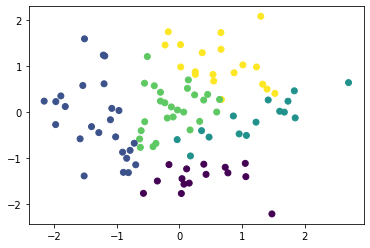

In [119]:
# graph points and color them according to their cluster
bbg = BBG(alpha=0.0001, epsilon=0.00001)
clusters = bbg.run(points, 5)
plt.scatter(points[:, 0], points[:, 1], c=clusters)
plt.show()

In [107]:
a = np.zeros(5)
a[1] = a[4] = a[2] = 1
b = np.zeros(5)
b[1] = b[2] = b[3] = 1
print(a, b, np.logical_and(a, b))

[0. 1. 1. 0. 1.] [0. 1. 1. 1. 0.] [False  True  True False False]
